In [2]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import interval_dict, annualize_returns, annualize_vol

warnings.filterwarnings('ignore')

The code below queries Yahoo Finance, to get EOD prices per ticker with different frequencies, also queries market caps per ticker (all converted to USD) and USD interest rates via the 13 week treasury bill as a proxy.

In [247]:
def get_yf_ts(ticker, period, interval):
    df = yf.Ticker(ticker).history(period=period, interval=interval)[['Close']].rename(columns={'Close' : ticker})
    df.index = df.index.to_period(interval_dict[interval])
    return df

def get_usd_mcap(ticker):
    info = yf.Ticker(ticker).info
    mcap, ccy = info['marketCap'], info['currency']
    if ccy != 'USD': # If not a US stock, convert market cap in USD using previous close FX
        fx = yf.Ticker('{}USD=X'.format(ccy)).info['previousClose']
        return mcap * fx
    return mcap

period = '5y'
interval = '1mo'
tickers = ['MSFT', 'AAPL', '2222.SR', 'NVO', 'TSLA', 'JPM', 'KO', 'SHEL', 'BMW.DE']
dfs = [get_yf_ts(ticker, period, interval) for ticker in tickers]
df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)

rf = get_yf_ts("^IRX", period, interval) / 100 # Expressed in % hence the division
intervals = df.shape[0]

mcaps = np.array([get_usd_mcap(ticker) for ticker in tickers]) # Market cap in USD for each of the tickers

In [4]:
returns = df.pct_change().dropna() # Despite the different currencies, we can use this set as we only track relative returns and disregard any friction from cross currency rebalances
cov_mat = returns.cov()

For the example subset we see the correlation of the returns time-series:

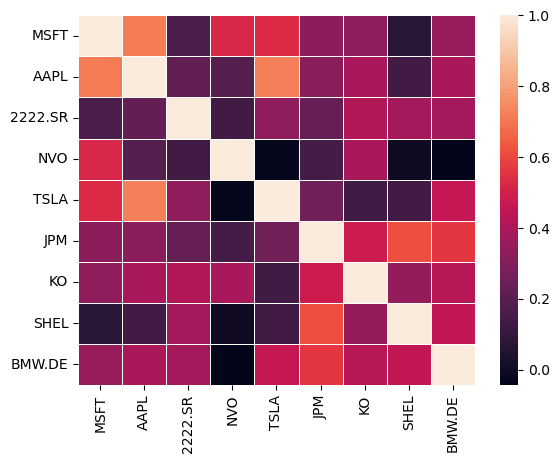

In [5]:
ax = sns.heatmap(returns.corr(), linewidth=0.5)
plt.show()

The portfolio return $w^Tr$ is just the dot product of its weights and the annualized returns per ticker:

In [138]:
portfolio_return = lambda w, r: np.dot(w, r)

The volatility of the portfolio however, it's the covariance of each pair of tickers scaled with its weight. For the same tickers that will simply be their variance and for different tickers its the result of the covariance matrix:
$$\sigma_p^2 = \sum_{i=1}^n \sum_{j=1}^n w_i w_j \text{Cov}(r_i, r_j)$$

In [278]:
def portfolio_vol(weights, returns, cov_mat): # A bit unconventional with the loop, but find it easier to follow than the dot product short version
    vol = sum(weights ** 2 * returns.std() ** 2) 
    for x,y in list(itertools.combinations(range(len(weights)), 2)):
        vol += 2 * weights[x] * weights[y] * cov_mat.iloc[x,y]
    return np.sqrt(vol) * np.sqrt(12)

For a given target return $r$, a return vector per ticker $\hat{r}$ and a covariance matrix for the tickers $\hat{\Sigma}$, the below function finds the portfolio weights that minimize the volatility, meeting the target return. $$\arg\min_w w^T\hat{\Sigma}w \text{ s.t. } w^T\hat{r}=r \text{ and } w^T1=1$$

In [279]:
def minimize_vol(tr, r, cov_mat):
    w = cp.Variable(r.shape[0])
    cp.Problem(cp.Minimize(cp.quad_form(w, cov_mat)), [cp.sum(w) == 1, w >= 0, w @ r == tr]).solve(solver='CPLEX')
    return np.array(w.value)

The below function calculates the <b>efficient frontier</b>, that is for each target return in $[\min(r), \max(r)]$ discretized in $N$ steps, it finds a portfolio (weights) that minimize its volatility:

In [280]:
def portfolio_ef(r_ann, r, cov_mat, N):
    df = pd.DataFrame()
    for ret in np.linspace(r_ann.min(), r_ann.max(), N):
        weights = minimize_vol(ret, r_ann, cov_mat)
        vol = portfolio_vol(weights, r, cov_mat)
        df = df.append(pd.DataFrame({'RET' : [ret], 'VOL' : [vol], 'WEIGHTS' : [weights]}))
    return df

In [281]:
rf_ann = annualize_returns(rf, intervals, 1)[0] # The 3 month UST is an annual rate already, hence the period=1
r_ann = annualize_returns(returns, intervals, 12)

In [282]:
ef_df = portfolio_ef(r_ann, returns, cov_mat, 20)

For the set of tickers that we have, we plot the efficient frontier and observe the return per unit volatility, note anything not on the EF line is considered suboptimal, because for the same amount of volatility gives lower return.

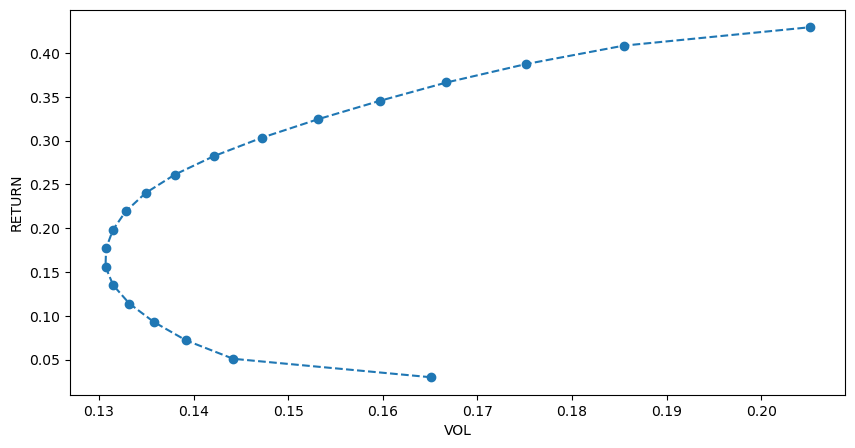

In [283]:
plt.figure(figsize=(10,5))
plt.plot(ef_df['VOL'], ef_df['RET'], marker='o', linestyle='dashed')
plt.xlabel('VOL')
plt.ylabel('RETURN')
plt.show()

The <b>Sharpe ratio</b> measures the performance of the portfolio (discounted by a risk-free asset) compared to its volatility.
Also introduced is a maximization function, that finds the highest sharpe ratio for a given set of returns, a benchmark risk-free return and a covariance matrix. $$S_a=\frac{E[R_a-R_f]}{\sigma_a}$$

In [284]:
def sharpe(weights, rf, r, cov_mat):
    r = portfolio_return(weights, r)
    vol = portfolio_vol(weights, returns, cov_mat)
    return (r - rf) / vol

def max_sharpe(rf, r, cov):
    n = r.shape[0]
    neg_sharpe = lambda w, rf, r, cov_mat: -sharpe(w, rf, r, cov_mat) # Because scipy can only minimize
    w = sp.optimize.minimize(fun=neg_sharpe, x0=np.repeat(1 / n, n), args=(rf, r, cov), bounds=[(0,1)] * n,
                                   constraints={'type': 'eq', 'fun': lambda w: w.sum() - 1})
    return w.x

A helper function to give us the summary of each constructed portfolio in this notebook. What is its return, its weights, volatility and sharpe ratio.

In [300]:
def portfolio_summary(weights, rf_ann, r_ann, returns, cov_mat, name=''):
    p_return, p_vol = portfolio_return(weights, r_ann), portfolio_vol(weights, returns, cov_mat)
    sharpe_ratio = (p_return - rf_ann) / p_vol
    return pd.DataFrame({'RETURN' : [p_return], 'VOL' : [p_vol], 'SHARPE_RATIO' : [sharpe_ratio]}, index=[name])

In [312]:
sharpe_weights = pd.Series(max_sharpe(rf_ann, r_ann, cov_mat), index=tickers, name='WEIGHTS').round(3)
sharpe_summary = portfolio_summary(sharpe_weights, rf_ann, r_ann, returns, cov_mat, 'SHARPE')

display(sharpe_weights.to_frame().T)
display(sharpe_summary)

,MSFT,AAPL,2222.SR,NVO,TSLA,JPM,KO,SHEL,BMW.DE
WEIGHTS,0.0,0.0,0.0,0.84,0.05,0.0,0.0,0.046,0.064


,RETURN,VOL,SHARPE_RATIO
SHARPE,0.396019,0.179059,2.076871


The <b>global minimum volatility portfolio (GMV)</b> is the portfolio with the lowest volatility and the highest return for that risk level. 

In [315]:
gmv_weights = pd.Series(max_sharpe(0, r_ann, cov_mat), index=tickers, name='WEIGHTS').round(3) # By replacing the risk free rate with 0, we are maximizing return / vol
gmv_summary = portfolio_summary(gmv_weights, rf_ann, r_ann, returns, cov_mat, 'GMV')

display(gmv_weights.to_frame().T)
display(gmv_summary)

,MSFT,AAPL,2222.SR,NVO,TSLA,JPM,KO,SHEL,BMW.DE
WEIGHTS,0.0,0.0,0.0,0.822,0.046,0.0,0.0,0.058,0.074


,RETURN,VOL,SHARPE_RATIO
GMV,0.389601,0.176061,2.075785


Below we introduce the <b>market cap weighted portfolio</b>, similar to how many famous indices are constructed:

In [317]:
mcap_weights = pd.Series(mcaps / mcaps.sum(), index=tickers, name='WEIGHTS').round(3)
mcap_summary = portfolio_summary(mcap_weights, rf_ann, r_ann, returns, cov_mat, 'MCAP')

display(mcap_weights.to_frame().T)
display(mcap_summary)

,MSFT,AAPL,2222.SR,NVO,TSLA,JPM,KO,SHEL,BMW.DE
WEIGHTS,0.309,0.3,0.166,0.06,0.059,0.054,0.025,0.021,0.006


,RETURN,VOL,SHARPE_RATIO
MCAP,0.220752,0.207533,0.947393


The simplest <b>equally weighted portfolio</b>:

In [370]:
ew_weights = np.repeat(1 / len(tickers), len(tickers))
ew_summary = portfolio_summary(ew_weights, rf_ann, r_ann, returns, cov_mat, 'EW')
display(ew_summary)

,RETURN,VOL,SHARPE_RATIO
EW,0.202254,0.200019,0.890503


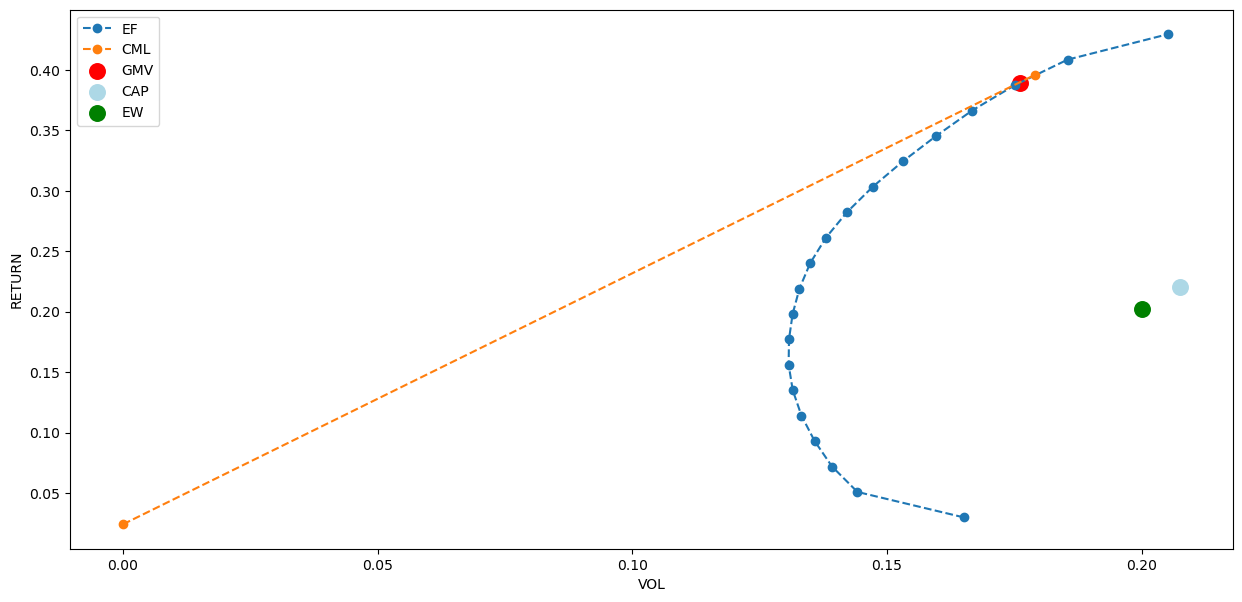

In [320]:
plt.figure(figsize=(15,7))
plt.plot(ef_df['VOL'], ef_df['RET'], marker='o', linestyle='dashed', label='EF')
plt.plot([0, sharpe_summary['VOL'].iloc[0]], [rf_ann, sharpe_summary['RETURN'].iloc[0]], marker='o', linestyle='dashed', label='CML') # The capital market line (CML)
plt.scatter(gmv_summary['VOL'], gmv_summary['RETURN'], marker='o', label='GMV', s=125, color='red') # Global minimum volatility portfolio (GMV)
plt.scatter(mcap_summary['VOL'], mcap_summary['RETURN'], marker='o', label='CAP', s=125, color='lightblue') # Market cap weighted portfolio
plt.scatter(ew_summary['VOL'], ew_summary['RETURN'], marker='o', label='EW', s=125, color='green') # Equally weighted portfolio
plt.legend()
plt.xlabel('VOL')
plt.ylabel('RETURN')
plt.show()

Given we've set the weights for each portfolio, we run them on past data and observe how they perform:

In [368]:
portfolio_backtest = lambda weights, returns : ((1 + returns) * weights).sum(axis=1)

For an initial investment of $1000, without rebalancing, for the last 5y each portfolio would have made:


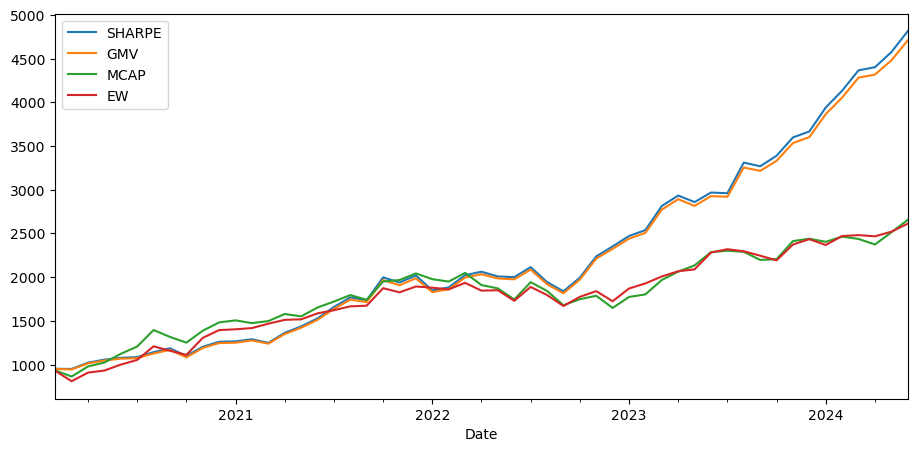

In [403]:
init_inv = 1000
print('For an initial investment of ${}, without rebalancing, for the last {} each portfolio would have made:'.format(init_inv, period))
plt.figure(figsize=(11, 5))
(portfolio_backtest(sharpe_weights, returns).cumprod() * init_inv).plot(label='SHARPE')
(portfolio_backtest(gmv_weights, returns).cumprod() * init_inv).plot(label='GMV')
(portfolio_backtest(mcap_weights, returns).cumprod() * init_inv).plot(label='MCAP')
(portfolio_backtest(ew_weights, returns).cumprod() * init_inv).plot(label='EW')
plt.legend()
plt.show()

Finally, we observe how each stock would've performed on its own:

,MSFT,AAPL,2222.SR,NVO,TSLA,JPM,KO,SHEL,BMW.DE
WEIGHTS,0.0,0.0,0.0,0.84,0.05,0.0,0.0,0.046,0.064


From the below plot, clear why highest weight is put on NVO, as it has the highest return and low volatility


<AxesSubplot:xlabel='Date'>

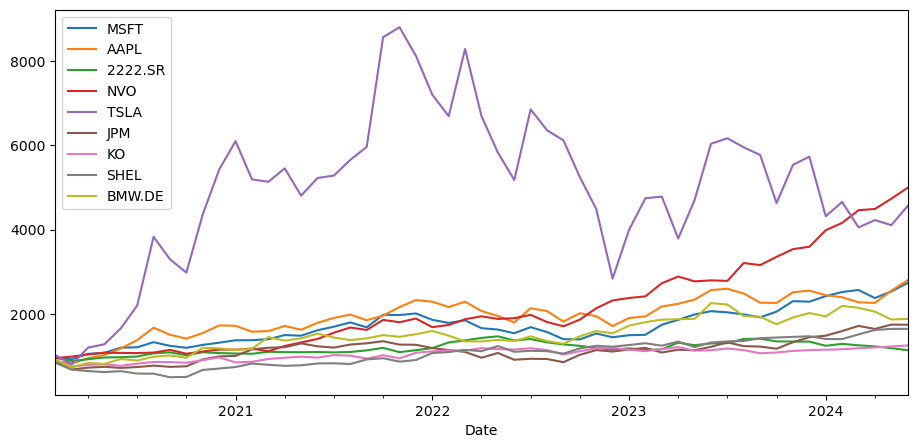

In [402]:
display(sharpe_weights.to_frame().T)
print('From the below plot, clear why highest weight is put on {}, as it has the highest return and low volatility'.format(sharpe_weights.idxmax()))
((1 + returns).cumprod() * 1000).plot(figsize=(11,5))